# Predict hand gesture using a trained model
## Import modules
* __serial:__ To receive acceleration data from BBC Microbit connected through USB with the laptop
* __numpy:__ To handle numpy arrays
* __matplotlib:__ To plot the graph of the received data
* __keras:__ To load the trained model

In [1]:
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, "src")
from Utils import pad_constant, uniform_split, load_raw_data, LABELS

__Utils__ module contains some custom functions and is located in the __src__ directory of our project. By adding __src__ in the system path, we can import the modules from it directly.
Description of the functions loaded from __Utils__ modules are as follows:
* __pad_constant:__ Pads a given array at the start with initial value or at the end at final value to achieve given item length
* __load_raw_data:__ Processes an array with raw acceleration data by smoothing and normalising it

__LABELS__ is a tuple with labels of the gestures.

## Load Model
Load a trained model from the **Models** directory.

In [3]:
model = load_model(r"Models/Model 96.11 12.06.2019 00.12.HDF5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Receive data through serial communication from the  BBC Microbit
The dictionary CONFIG holds the configuration for the serial communication via USB between the program and the BBC Microbit.

Make sure the **port** id is correct.

In [4]:
CONFIG = {"port":"COM5", "baudrate":115200, "bytesize":8, "parity":"N", "stopbits":1}
with serial.Serial(**CONFIG) as ser:
    raw_data = []
    i = 0
    print("# Waiting for data")
    while True:
        sample_data = ser.readline()
        if sample_data.startswith(b"done"):
            print("\n  Done")
            break
        elif b"," in sample_data:
            print("  Receiving data {:<15}".format("."*i), end="\r")
            raw_data.append(sample_data)
            i = i+1 if (i < 15) else 0
    ser.close()

# Waiting for data
  Receiving data ...........    
  Done


## Load and Process data
Using the file name, we determine the label of the gesture and append it to the **labels** list.

Then we load all the files we want to test using **load_raw_data** function. Through the parameters of this function, we can control the columns to be loaded **(cols)**, width of the moving average window **(movingAvgWindow)** and whether to normalize the loaded data or not **(normalize)**. Afterwards, each axis reading of the loaded data is padded at the start with its initial value to achieve the data length mentioned in **review_length** variable. Then each axis reading is reshaped and appended to the particular index of the **final_data** array depending on the axis type.

Finally, the class vector (integers) of the loaded **labels** are converted to binary class matrix using the **to_categorical** function from **keras** module.

In [5]:
final_data = [[], [], []]           # Stores all processed data; [[x-axis], [y-axis], [z-axis]]
review_length = 150                 # Review length: length of each data after padding

fmt_data = [list(map(int, row.strip(b"()\n").split(b","))) for row in raw_data]
columns = ("x", "y", "z")
df = pd.DataFrame(fmt_data, columns=columns)
df.columns = pd.Index([i.strip() for i in df.columns])
data = load_raw_data(df, cols=columns, movingAvgWindow=13, normalizeData=True)
data = uniform_split(data, parts=len(columns))
for i, array in enumerate(data):
    array = pad_constant(array, max_length=review_length, pad_pos="start")
    array = np.reshape(array, (1, array.shape[0]))
    final_data[i].append(array)

## Plotting graph
Here we plot the acceleration data of all the planes on the y-axis and time sampled at interval of 100 ms on the x-axis.

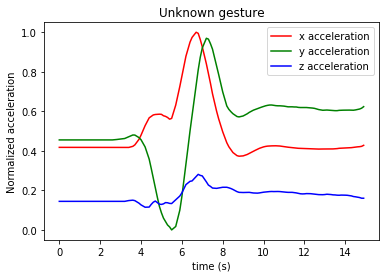

In [6]:
sample_period = 0.1
t = np.arange(review_length)*sample_period            # Time range for each plot
x, y, z = final_data
plt.title("Unknown gesture")
plt.xlabel("time (s)")
plt.ylabel("Normalized acceleration")
plt.plot(t, np.array(x).reshape(review_length,), "r", label="x acceleration")
plt.plot(t, np.array(y).reshape(review_length,), "g", label="y acceleration")
plt.plot(t, np.array(z).reshape(review_length,), "b", label="z acceleration")
plt.legend()

## Determine accuracy
From the sampled data, we try to predict its label using our trained model.

In [7]:
predicted_label = LABELS[np.argmax(model.predict(final_data), axis=1)[0]]
print("Predicted motion:", predicted_label.upper())

Predicted motion: RIGHT
